# Applying Non-Negative Matrix Factorization to NBA Shooting Data

Non-negative matrix factorization (NNMF) is an unsupervised learning and dimensionality reduction technique that can be used to find hidden-structures in data. In this project, I use NNMF to uncover structure NBA shooting data. Using NNMF still involves trial and error, as it is difficult (if not impossible) to predict how many components you should decompose the data into to find the most interpretable output. See the NNMF section for more details.

The project is broken down into four parts:

1. Scraping the required data via Beautiful Soup; cleaning the data

2. Visualizing the data via matplotlib and seaborn

3. Implementing and applying NNMF algorithm from scratch

4. Summarize the output

# Data Collection

\* *Re-running the web scraper (particularly the shot data) takes ~ 1 hour. There are sleep times imposed between scrapes to avoid over-scraping the server*

In [ ]:
# External Libraries Used
# !pip install seaborn
# !pip install bs4
# !pip install pandas
# !pip install numpy

### Define Function for Scraping Season Schedule

In [2]:
import numpy as np
import pandas as pd
import re
import random
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from datetime import datetime
from time import sleep
from sklearn.decomposition import NMF

def get_schedule(season, playoffs=False):
    months = ['October', 'November', 'December', 'January', 'February', 'March', 'April', 'May']
    df = pd.DataFrame()
    
    for month in months:
        z = get(f'https://www.basketball-reference.com/leagues/NBA_{season}_games-{month.lower()}.html')
        if z.status_code==200:
            soup = BeautifulSoup(z.content, 'html.parser')
            table = soup.find('table', attrs={'id': 'schedule'})
            month_df = pd.read_html(str(table))[0]
            df = df.append(month_df)
        
    df = df.reset_index()
    cols_to_remove = [i for i in df.columns if 'Unnamed' in i] # Drop unnecessary columns
    cols_to_remove += [i for i in df.columns if 'Notes' in i]
    cols_to_remove += [i for i in df.columns if 'Start' in i]
    cols_to_remove += [i for i in df.columns if 'Attend' in i]
    cols_to_remove += ['index']
    df = df.drop(cols_to_remove, axis=1)
    df.columns = ['DATE', 'VISITOR', 'VISITOR_PTS', 'HOME', 'HOME_PTS']
    df = df[df.VISITOR != "Playoffs"] # Remove extra row that gets added when Playoffs start (non-sense data)
    df.DATE = pd.to_datetime(df.DATE)
    return df

### Scrape 2018 Season Schedule

In [373]:
schedule = get_schedule(2018) 
schedule.head()

,DATE,VISITOR,VISITOR_PTS,HOME,HOME_PTS
0,2017-10-17,Boston Celtics,99,Cleveland Cavaliers,102
1,2017-10-17,Houston Rockets,122,Golden State Warriors,121
2,2017-10-18,Charlotte Hornets,90,Detroit Pistons,102
3,2017-10-18,Brooklyn Nets,131,Indiana Pacers,140
4,2017-10-18,Miami Heat,109,Orlando Magic,116


### Create Abreviation Lookup Dictionary
Define Team Abbreviation dictionary. These abbreviations are needed to scrape the shot charts for each game. I will use the last word of each team name ('mascot') as the keys since they are unique.

In [367]:
teams = {'Hawks': 'ATL',
 'Nets': 'BRK',
 'Celtics': 'BOS',
 'Hornets': 'CHO',
 'Bulls': 'CHI',
 'Cavaliers': 'CLE',
 'Mavericks': 'DAL',
 'Nuggets': 'DEN',
 'Pistons': 'DET',
 'Warriors': 'GSW',
 'Rockets': 'HOU',
 'Pacers': 'IND',
 'Clippers': 'LAC',
 'Lakers': 'LAL',
 'Grizzlies': 'MEM',
 'Heat': 'MIA',
 'Bucks': 'MIL',
 'Timberwolves': 'MIN',
 'Pelicans': 'NOP',
 'Knicks': 'NYK',
 'Thunder': 'OKC',
 'Magic': 'ORL',
 '76ers': 'PHI',
 'Suns': 'PHO',
 'Blazers': 'POR',
 'Kings': 'SAC',
 'Spurs': 'SAS',
 'Raptors': 'TOR',
 'Jazz': 'UTA',
 'Wizards': 'WAS'}

### Define Functions to Scrape Shot Chart 

In [368]:
def get_game_suffix(date, home_team): # Get the suffix for the shot chart URL
    z = get(f'https://www.basketball-reference.com/boxscores/index.fcgi?year={date.year}&month={date.month}&day={date.day}')
    suffix = None
    home_team = teams[home_team.split()[-1]]
    if z.status_code==200:
        soup = BeautifulSoup(z.content, 'html.parser')
        for table in soup.find_all('table', attrs={'class': 'teams'}):
            for anchor in table.find_all('a'):
                if 'boxscores' in anchor.attrs['href']:
                    if home_team in anchor.attrs['href']:
                        suffix = anchor.attrs['href']
                        return suffix
    return

def get_location(s): # Convert shot locations (pixels) to feet
    l = s.split(';')
    top = float(l[0][l[0].index(':')+1:l[0].index('px')])
    left = float(l[1][l[1].index(':')+1:l[1].index('px')])
    x = left/500.0*50 # NBA halfcourt is 50ft wide
    y = top/472.0*(94/2) # NBA halfcout is 47ft long
    return {'x': round(x,2), 'y': round(y,2)} 

def get_description(s): # Parse for descriptive shot data as per the listed column names
    match = re.match(r'(\d)[a-z]{2} quarter, (\S*) remaining<br>(.*) \b(missed|made) (\d)-pointer from (\d*) ft', s)
    d = {}
    if match:
        groups = match.groups()
        d['QUARTER'] = int(groups[0])
        d['TIME_REMAINING'] = groups[1]
        d['PLAYER'] = groups[2]
        d['MAKE_MISS'] = 'MAKE' if groups[3]=='made' else 'MISS'
        d['VALUE'] = int(groups[4])
        d['DISTANCE'] = groups[5] + ' ft'
    return d

def get_shot_chart(date, team1, team2): # Function returns a dataframe containing detailed shot information
    suffix = get_game_suffix(date, team2).replace('/boxscores', '')
    r = get(f'https://www.basketball-reference.com/boxscores/shot-chart{suffix}')
    team1 = teams[team1.split()[-1]]
    team2 = teams[team2.split()[-1]]
    if r.status_code==200:
        soup = BeautifulSoup(r.content, 'html.parser')
        shot_chart1_div = soup.find('div', attrs={'id': f'shots-{team1}'})
        shot_chart2_div = soup.find('div', attrs={'id': f'shots-{team2}'})
        df = pd.DataFrame()
        for div in shot_chart1_div.find_all('div'):
            if 'style' not in div.attrs or 'tip' not in div.attrs:
                continue
            location = get_location(div.attrs['style'])
            description = get_description(div.attrs['tip'])
            shot_d = {**location, **description}
            shot_df = pd.DataFrame.from_dict([shot_d])
            df = df.append(shot_df)
        df = df.reset_index()
        df = df.drop('index', axis=1)
        
        for div in shot_chart2_div.find_all('div'):
            if 'style' not in div.attrs or 'tip' not in div.attrs:
                continue
            location = get_location(div.attrs['style'])
            description = get_description(div.attrs['tip'])
            shot_d = {**location, **description}
            shot_df = pd.DataFrame.from_dict([shot_d])
            df = df.append(shot_df)
        df = df.reset_index()
        df = df.drop('index', axis=1)
        sleep(random.uniform(1,2))
        return df

In [371]:
# Let's visualize Kyrie Irvings Shot Chart from Boston's first game of the 2017 - 2018 season for verification
test_chart = get_shot_chart(schedule.DATE[0], schedule.VISITOR[0], schedule.HOME[0])

# Convert x measurements to coordinate system of basketball court
test_chart['x_conv'] = test_chart.apply(lambda row: (row['x']-25)*10, axis = 1)

# Convert y measurements to coordinate system of basketball court
test_chart['y_conv'] = test_chart.apply(lambda row: row['y']*10-47.5, axis = 1) 

# Clean up DataFrame
kyrie = test_chart[test_chart['PLAYER'] == 'Kyrie Irving'].reset_index().drop('index', axis = 1)

kyrie.head()

,x,y,QUARTER,TIME_REMAINING,PLAYER,MAKE_MISS,VALUE,DISTANCE,x_conv,y_conv
0,23.9,12.94,1,11:44.0,Kyrie Irving,MAKE,2,10 ft,-11.0,81.9
1,23.3,6.07,1,8:34.0,Kyrie Irving,MISS,2,3 ft,-17.0,13.2
2,34.9,15.04,1,8:02.0,Kyrie Irving,MAKE,2,16 ft,99.0,102.9
3,30.5,17.13,1,5:31.0,Kyrie Irving,MAKE,2,15 ft,55.0,123.8
4,30.4,26.59,1,4:56.0,Kyrie Irving,MISS,3,24 ft,54.0,218.4


### Scrape Full Dataset

In [19]:
# Scrape entire schedule (this is time consuming)
schedule['Shot_Chart'] = schedule.apply(lambda x: get_shot_chart(x['DATE'], x['VISITOR'], x['HOME']), axis = 1)
schedule.head()

,DATE,VISITOR,VISITOR_PTS,HOME,HOME_PTS,Shot_Chart
0,2017-10-17,Boston Celtics,99,Cleveland Cavaliers,102,x y QUARTER TIME_REMAINING ...
1,2017-10-17,Houston Rockets,122,Golden State Warriors,121,x y QUARTER TIME_REMAINING ...
2,2017-10-18,Charlotte Hornets,90,Detroit Pistons,102,x y QUARTER TIME_REMAINING ...
3,2017-10-18,Brooklyn Nets,131,Indiana Pacers,140,x y QUARTER TIME_REMAINING ...
4,2017-10-18,Miami Heat,109,Orlando Magic,116,x y QUARTER TIME_REMAINING ...


Create new dataframe that is a concatenation of the shot chart in each row of the shot_chart column

In [22]:
cols = ['x', 'y', 'QUARTER', 'TIME_REMAINING', 'PLAYER', 'MAKE_MISS', 'VALUE', 'DISTANCE']
all_data = pd.DataFrame(columns = cols)

for i in range(schedule.shape[0] - 2):
    df = schedule.iloc[i].Shot_Chart
    all_data = pd.concat([all_data, df], ignore_index = True, sort=False)

all_data.head()

all_data.to_csv("shot-chart.csv") # save to file

,x,y,QUARTER,TIME_REMAINING,PLAYER,MAKE_MISS,VALUE,DISTANCE
0,23.9,12.94,1,11:44.0,Kyrie Irving,MAKE,2,10 ft
1,2.6,16.73,1,11:21.0,Gordon Hayward,MISS,3,25 ft
2,25.0,5.28,1,10:51.0,Jayson Tatum,MISS,2,2 ft
3,28.7,21.91,1,10:48.0,Al Horford,MAKE,2,19 ft
4,22.9,3.58,1,9:33.0,Jaylen Brown,MISS,2,1 ft


# Visualizations

Define function to draw NBA halfcourt with proper dimensions

### Drawing the Base Image (Basketball Court)

In [369]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Diameter of a hoop is 18" so it has a radius of 9", which is a value 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The Key: Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color, fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color, fill=False)
    
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,linewidth=lw, color=color, linestyle='dashed')
    
    # Restricted Zone: 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color)

    # Three point line
    
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw, color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop. Thetas are via trial and error until aligned
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0, linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw, bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

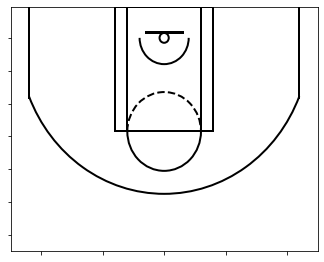

In [370]:
# Visualize the court
plt.figure(figsize=(5.5,4.5))
plt.xlim(-250,250)
plt.ylim(325, -47.5) # Draw portion of court pretaining to set offense (I.e. shooting from half court is never the goal)
plt.tick_params(labelbottom=False, labelleft=False)
draw_court(outer_lines = False)
plt.show()

### Plot Kyrie Irving Shot chart for Game 1 of 2018 Season

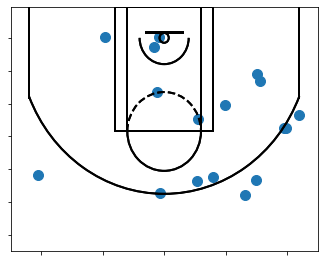

In [374]:
# Plot Kyrie Irving Shot Chart
plt.figure(figsize=(5.5,4.5))
plt.scatter(kyrie.x_conv,kyrie.y_conv, s=100)
draw_court(outer_lines = False)

# Adjust plot limits to focus on halfcourt offense (shots taken near half are rarely if ever intentional parts of offense)
plt.xlim(-250,250)
plt.ylim(325, -47.5)
plt.tick_params(labelbottom=False, labelleft=False)
draw_court(outer_lines = False)
plt.show()

# Aggregate Shot Data for All Games

### Clean up some non-sensical portions of the data:
* Negative x and y values should be impossible. Presumed to be measuremenet error in sensors use dto determine locations
* x, y must be positive values for non-negative matrix factorization
* Drop columns with NA. Low % of total data and it cannot be used / should not exist in the dataset

In [24]:
all_data[all_data.x < 0] = 0
all_data[all_data.y < 0] = 0
all_data = all_data.dropna()

### Discretize Shot Locations
In order to apply NNMF, we need discrete bins for each shot to limit total number of possible values. The simplest approach is simply to round the x and y values of each shot

In [27]:
all_data['x_bin'] = (np.round(all_data.x)).astype(int)
all_data['y_bin'] = (np.round(all_data.y)).astype(int)

# Summarize Players into bin / count dictionary:
all_data['zip'] = tuple(zip(all_data.x_bin, all_data.y_bin)) 

# Visualizing Season Length Heatmap

Below I will plot the heatmaps for several high-profile players to check if the player anectodes hold true mathematically.

In [259]:
def plot_player(data, name, cmap=plt.cm.jet): #color map for heatmap 
    df = copy.deepcopy(data.loc[data['PLAYER'] == name])
    df['x_plot'] = df.apply(lambda row: (row['x_bin']-24)*10, axis = 1)
    df['y_plot'] = df.apply(lambda row: row['y_bin']*10 - 47.5, axis = 1)
    
# Joint shot chart produces histo / heatmap. n_levels refers to # of contour lines in kde plot
    joint_shot_chart = sns.jointplot(df.x_plot,df.y_plot, stat_func=None, kind='kde', space=0, color=cmap(0.1),
                                 cmap=cmap, n_levels=10)

    joint_shot_chart.fig.set_size_inches(5,3.5)

    # A joint plot has 3 Axes, the first one ax_joint is the one we want to draw our court onto and adjust some other settings
    ax = joint_shot_chart.ax_joint

    # Adjust the axis limits and orientation of the plot in order to plot half court, with the hoop by the top of the plot
    ax.set_xlim(-250,250)
    ax.set_ylim(350, -47.5)

    # Get rid of axis labels and tick marks
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelbottom='off', labelleft='off')
    draw_court(ax)
    plt.show()
    
    return

### James Harden

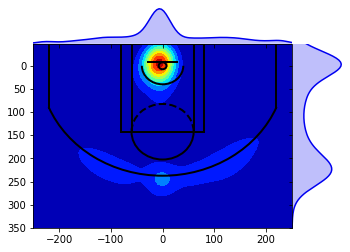

In [260]:
plot_player(all_data, "James Harden")

Looking at James Harden's heatmap, we see that the virtually all of his shots come from either within the restricted area (on the left side), or the top of the three point line. This makes sense because James Harden is a left handed player, and is known for virtually never shooting midrange shots. Midrange shots are considered the least statistically efficient shots to take, so instead he focuses almost exclusively on three pointers and drives to the basket. As the primary ball handler, most of his three pointers come from the top of the three point line. As a left-dominant ball handler, most of his shots close to the basket come from the left side. 

### LeBron James

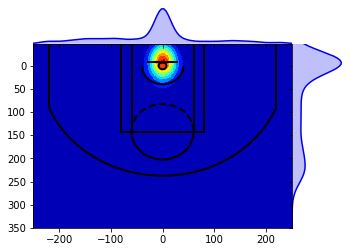

In [261]:
plot_player(all_data, "LeBron James")

The vast majority of LeBron's shots come at the hoop. Known for his relentless driving to the basket, there are very few shoots that don't come from within the restricted area. 

### Steph Curry

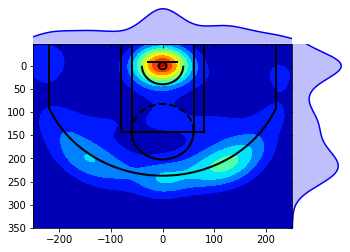

In [262]:
plot_player(all_data, "Stephen Curry")

Steph Curry's shot distribution is as expected. Primarily finishing creatively at the basket, or shooting threes (with slight emphasis on the right side). As the primary ball handler, he rarely has the ball in the corner. As a result, we see no mid-range shooting from left or right sides. 

### Klay Thompson

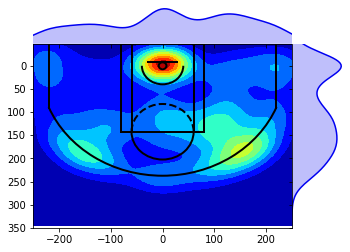

In [263]:
plot_player(all_data, "Klay Thompson")

Like Steph Curry, Klay Thompson is also a prolific three-point shooter. However, we see significantly more mid-range game than his peer, and actually a larger proportion of shots come from three. As a non-primary ball handler, we don't see many keys come from the very top of the three point line (compared to Steph, for example). We also see an uptick in corner threes from the right hand side - the result of a teammate driving to the hoop and passing it out to him in the corner for three. 

### LaMarcus Aldridge

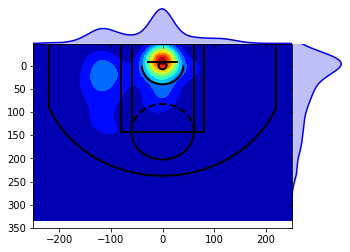

In [264]:
plot_player(all_data, "LaMarcus Aldridge")

LeMarcus is known for his mid-range post ups on the lefthand side. This is very telling, as virtually none of his shots come from outside the restricted area of the left-midrange area. 

### JJ Redick

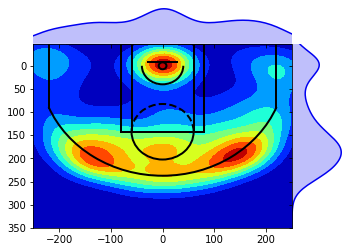

In [265]:
plot_player(all_data, "J.J. Redick")

As a three point specialist, we see a much large proportion of his shots coming from the three point line compared to his peers.

### Kawhi Leonard

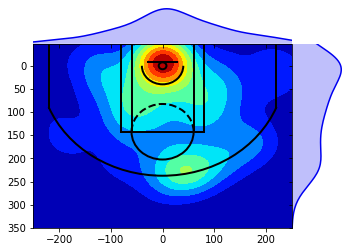

In [266]:
plot_player(all_data, "Kawhi Leonard")

Kawhi Leonard is perhaps the most prolific midrange scorer in the game today. Here we see his shot selection casts a wide geographic net, and is pretty evenly distributed.

# Define NNMF

The NNMF algorithm is essentially a gradient-descent algorithm that solves the nonnegative matrix factorization problem: 
$$
\begin{align*}
\mbox{minimize}_{W,H} &  \ \| WH-X\|_F^2\\
\mbox{subj. to} & \ W_{ij}\ge 0 \ \forall i,j \\
                &  \ H_{ij}\ge 0 \ \forall i,j
\end{align*}
$$
where $W\in\mathbb{R}^{m\times r}$ and $H\in\mathbb{R}^{r\times n}$.

* $W$ matrix represents the hidden structure of the shooting data. That is to say, the player arch-types that we are summarizing the shot data into will be columns of W
* $r$ represents the number of columns we want to decompose our data matrix into (I.e. how many archetypes are there?). Note that finding the "correct" r value for the "best" W matrix is as much an art as a science
* $H$ will represent a weight matrix corresponding to the components of W that most make contribute to a specific players shot chart

For more info:    
https://en.wikipedia.org/wiki/Non-negative_matrix_factorization   
https://blog.acolyer.org/2019/02/18/the-why-and-how-of-nonnegative-matrix-factorization/

In the code below, delta and sigma are small values designed to prevent the numerator or denominator of the step-size from being 0. Numerator of 0 can cause the gradient step size to be 0 (effectively stalling the algorithm out), and the a denominator of 0 will break the algorithm. Epsilon is just a parameter that defines convergence tolerance (I.e. what change in objective function between iterations is small enough such that we can practically consider the algorithm to have converged?)

In [378]:
def get_gradient_H(W, H, X):
    return W.T@W@H - W.T@X

def get_gradient_W(W, H, X):
    return W@(H@H.T) - X@H.T

def get_stepsize_H(W, H, X, gradient_H, delta, sigma):
    H_bar = np.where(gradient_H >= 0, H, np.maximum(H, sigma))
    return H_bar/(W.T@W@H_bar + delta)

def get_stepsize_W(W, H, X, gradient_W, delta, sigma):
    W_bar = np.where(gradient_W >= 0, W, np.maximum(W, sigma))
    return W_bar/(W_bar@(H@H.T) + delta)

def NNMF(X, r=6, delta=1.0e-9, sigma=1.0e-9, maxIter=200): # accepts column vectors
    W = np.random.uniform(size=(X.shape[0], r))
    H = np.random.uniform(size=(r, X.shape[1]))
    for _ in range(maxIter):
        gradient_H = get_gradient_H(W, H, X)
        stepsize_H = get_stepsize_H(W, H, X, gradient_H, delta, sigma) 
        H -= stepsize_H*gradient_H
        gradient_W = get_gradient_W(W, H, X)
        stepsize_W = get_stepsize_W(W, H, X, gradient_W, delta, sigma)
        W -= stepsize_W*gradient_W
    return W, H

# Stage Data for NNMF

In order to apply NNMF, I need to create column vectors. To do this, I will first create a zero array in the dimensions of my shot bins. Then, I will reshape this to a flat column vector. Lastly, I will Combine the column vector for all players into an array (this is my X array in the NNMF algorithm). There may be an opportunity to take advantage of sparsity in the data.

In [436]:
shape = (50, 47) # court dimensions in ft 

def shot_dictionary(name):
    temp = (all_data[all_data.PLAYER == name]).copy()
    shot_dict = dict(temp['zip'].value_counts())
    return shot_dict

def get_matrix(d, shape = shape):
    shots = np.zeros(shape)
    for k,v in d.items():
        shots[k] = int(v)
    return (np.matrix.flatten(shots)) # Normalize all players as if they shot 10,000 shots

new_df = pd.DataFrame(all_data.PLAYER.unique(), columns = ['PLAYER']) 
new_df['DICT'] = new_df.apply(lambda x: shot_dictionary(x.PLAYER), axis = 1)
new_df['MATRIX'] = new_df.apply(lambda x: get_matrix(x.DICT), axis = 1)
nmf_data = np.array(new_df["MATRIX"].values.tolist())

### Drop Players with < 100 shots

In [437]:
nmf_data = nmf_data[np.sum(nmf_data, axis = 1) >= 100]
nmf_data.shape

(390, 2350)

### Run NNMF & Visualize Output

In [438]:
r = 6
W, H = NNMF(nmf_data.T, r = r)
W = np.round(W).astype('int')

In [439]:
# re biuld a list of coordinates (repeated) in order to use seaborn jointplot (cannot use frequencies)
def conv_xy(data, shape = (50,47)):
    data = data.reshape(shape)
    x = np.array([])
    y = np.array([])
    for i in range(1,data.max()+1):
        for j in range(i):
            locs = np.where(data==i)
            try:
                x = np.append(x, locs[0])
                y = np.append(y, locs[1])
            except: #this number doesn't exist in the array
                break
                
    x = (x-24)*10
    y = y*10 - 47.5
    y[y <0 ] = 0
    x = np.append(x, [-250,250])
    y = np.append(y,[-47.5, 300])
    y = np.append(y,0)
    x = np.append(x,0)
    return x,y

In [440]:
def plot_heatmap(data, shape = shape, cmap=plt.cm.jet): #color map for heatmap
    x, y = conv_xy(data)
    
# Joint shot chart produces histo / heatmap. n_levels refers to # of contour lines in kde plot
    joint_shot_chart = sns.jointplot(x,y, stat_func=None, kind='kde', space=0, color=cmap(0.1),
                                 cmap=cmap, n_levels=8)

    joint_shot_chart.fig.set_size_inches(5,3.5)

    # A joint plot has 3 Axes, the first one ax_joint is the one we want to draw our court onto and adjust some other settings
    ax2 = joint_shot_chart.ax_joint

    # Adjust the axis limits and orientation of the plot in order to plot half court, with the hoop by the top of the plot
    ax2.set_xlim(-250,250)
    ax2.set_ylim(300, -47.5)

    # Get rid of axis labels and tick marks
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.tick_params(labelbottom='off', labelleft='off')
    draw_court(ax2)
    plt.show()
    
    return 


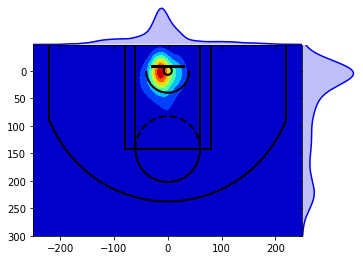

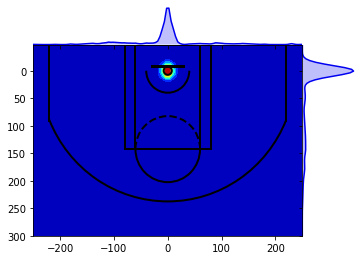

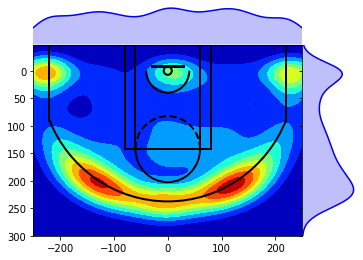

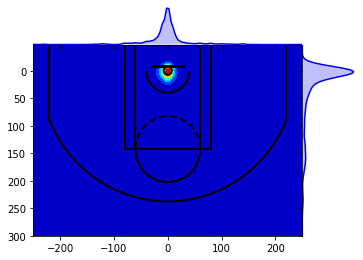

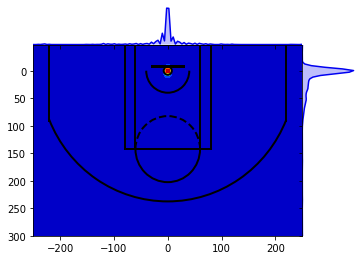

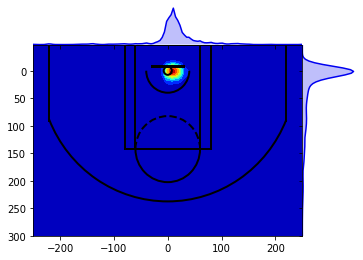

In [441]:
for i in range(r):
    plot_heatmap(W[:,i])

# Summary

Looking at the components above, we can observe the follow structured player-archtypes (in order):
1. Left-handed post players and drivers to the hoop
2. Drivers (players who score primarily off the dribble via layups on either side)
3. Shooters (focus on three pointers and mid-range)
4. More Drivers
5. Dunkers Only (Think "hustle players" who really only score in transition or via alley-oops)
6. Right-handed post players and drivers to the hoop

This result is slightly less diverse than anticipated, but there may be avenues to uncover additional structures (see below)

# Future Work 
The output was less diverse than I expected. I experimented with a few combinations of r values (n-components in sklearn model), but ran into a few issues. At certain times, entire components of r converge to a single shot location, which seems unrealistic and does not plot well. I would like to expand this project by trying:

1. Artificially scale all players to the same # of shots
    * Output may be dominated by low % of players shooting more shots) 
2. Increase amount of data: Append 2017 season data and re-test
    * Output may be due to limited total shot volume / diversity compared to bins
3. Double check the plotting adjustments I make to y-measurements
    * I may have inadvertently forced too many values to 0, which would explain why most segments are at the basket)
4. Explore H matrix to uncover what % of each structure a single players 
    * This will be more valuable with a more diverse set of components